## Problem statement

$$ \frac{\partial }{\partial x*} \left(  ( 1 + \epsilon_c \theta )  \frac{\partial \theta }{\partial x*} \right)   - N^2 \theta + N^2 G ( 1 + \epsilon_G \theta ) = 0   $$ 

#### Where: 

- $\theta(x) = \dfrac{T(x) - T_\inf}{T_{b} - T_{\inf}}$


- $N = \sqrt{\dfrac{h P L^2}{ k_0 A }} $


- $G=\dfrac{q_0A}{hP(T_b-T_\inf)}$


- $\epsilon_G=\epsilon(T_b-T_\inf)$


- $\epsilon_C=\beta(T_b-T_\inf)$

#### and the boundary conditions are:

- at $x^* = 0 \rightarrow \theta = 1$

- at $x^* = 1 \rightarrow \dfrac{d\theta}{dx^*} = 0$


**Given a sample which contains 9 values of $x$ and $\theta$ predict $G$** 

## Import libraries 

In [1]:
import torch
import torch.autograd as autograd         # computation graph
from torch import Tensor                  # tensor node in the computation graph
import torch.nn as nn                     # neural networks
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.

import pandas as pd
import matplotlib.pyplot as plt
# import matplotlib.gridspec as gridspec
# from mpl_toolkits.axes_grid1 import make_axes_locatable
# from mpl_toolkits.mplot3d import Axes3D
# import matplotlib.ticker
# from sklearn.model_selection import train_test_split

import numpy as np
import time
import scipy.io

## Hyper-parameters

In [51]:
seed_id = 565
# la 0,1, 2, 50 y la 250 andan
#  la seed 7623 = data 395 No anda 
# la 565 anda y tiene derivada segunda positiva pero el G da negatvio
steps = 10000
lr = 5e-3
nneurons = 20
nhiden_layers = 8
N_f = 40 #Total number of collocation points 
offset = .0001
G = 1.
N = 1.
ec = 1.
eg = 1.
print("Our initial of the other params are: \n N  = [",N,"]\n eg = [",eg,"] \n ec = [",ec,"]",  "\n G_PINN= [",G,"]")
device = 'cpu'

Our initial of the other params are: 
 N  = [ 1.0 ]
 eg = [ 1.0 ] 
 ec = [ 1.0 ] 
 G_PINN= [ 1.0 ]


## Set random seed and select device

In [52]:
#Set default dtype to float32
torch.set_default_dtype(torch.float)

#PyTorch random number generator
torch.manual_seed(seed_id)

# Random number generators in other libraries
np.random.seed(seed_id)


# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if device == 'cuda': 
    print(torch.cuda.get_device_name())
    
device = 'cpu'
print('Devuce employed:', device)

Devuce employed: cpu


## Load data

In [53]:
###### Load dataset
relative_csv_path = "./../src/data/raw/Dataset.csv"

# Load a random sample
fields_G = ['G']
fields_T = ['T1', 'T2', 'T3', 'T4' ,'T5', 'T6' ,'T7', 'T8' ,'T9']
fields = fields_T + fields_G
df_T = pd.read_csv(relative_csv_path, skipinitialspace=True, usecols=fields)
random_sample = df_T.sample()
print('The data used is form the sample:',random_sample.index[0])
G_real = random_sample[fields_G].to_numpy()
T_real = random_sample[fields_T].to_numpy().T
X_real = np.linspace(0,1,T_real.shape[0]).reshape(-1,1)
X_real = X_real.astype(np.float32)
X_bc = X_real[-1].reshape(-1,1)
print(X_real.shape)
print(X_bc.shape)

# compute theta 
T_inf = 27 + 273 #in K
T_b = 127 + 273 #in K
Theta_real = np.multiply(np.add(T_real, [-T_inf]), [1/(T_b - T_inf)])
Theta_real = Theta_real.astype(np.float32)
Theta_real = torch.from_numpy(Theta_real)
# prin shapes 
print('Theta real shape is:',Theta_real.shape)
print('X real shape is:',X_real.shape)
print('G_real is:',G_real)

# lower and uper bounds to normalize the input of net U
lb = min(X_real)
ub = max(X_real)
print('lb is %.2f and ub is %.2f' % (lb,ub))
N_u = Theta_real.shape[0]
print("The number real points are", N_u)

The data used is form the sample: 496
(9, 1)
(1, 1)
Theta real shape is: torch.Size([9, 1])
X real shape is: (9, 1)
G_real is: [[0.45670472]]
lb is 0.00 and ub is 1.00
The number real points are 9


### Collocation points ($loss_f$)

In [5]:
f_hat = torch.zeros(N_f,1).to(device)
theta_x_hat = torch.zeros(1,1).to(device)
print("The number of collocation points are", N_f)
X_train_f = torch.linspace(lb[0] + offset,ub[0] - offset,N_f).reshape(-1,1)

The number of collocation points are 40


## Define architecture 

In [6]:
input_dim = X_real.shape[1]
output_dim = Theta_real.shape[1]
layers = np.array([input_dim] + [ nneurons for i in range(nhiden_layers)] + [output_dim])
print("The number of layers selected are", layers.size-1)

The number of layers selected are 9


## Deep NN class

In [7]:
#  Deep Neural Network
class DNN(nn.Module):
    def __init__(self,layers):
        super().__init__() #call __init__ from parent class 
              
        'activation function'
        self.activation = nn.Tanh()
    
        'Initialize neural network as a list using nn.Modulelist'  
        self.linears = nn.ModuleList([nn.Linear(layers[i], layers[i+1]) for i in range(len(layers) - 1)])
    
        'Xavier Normal Initialization'
        for i in range(len(layers)-1):
            
            nn.init.xavier_normal_(self.linears[i].weight.data, gain=1.0)
            
            # set biases to zero
            nn.init.zeros_(self.linears[i].bias.data)
            
    'foward pass'
    def forward(self,x):
              
        if torch.is_tensor(x) != True:         
            x = torch.from_numpy(x)                
        
        u_b = torch.from_numpy(ub).float().to(device)
        l_b = torch.from_numpy(lb).float().to(device)
                      
        #preprocessing input 
        x = 2*(x - l_b)/(u_b - l_b)-1 #feature scaling
        
        #convert to float
        a = x.float()
        
        # inpunt and hidden layers forward computation
        for i in range(len(layers)-2):
            
            z = self.linears[i](a)
                        
            a = self.activation(z)

        # output layer forward computation            
        a = self.linears[-1](a)
        
        return a

## PINN class

In [8]:
class PINN():
    def __init__(self, layers):
        
        'Define loss function'
        self.loss_function = nn.MSELoss(reduction ='sum')
        
        'Initialize iterator'
        self.iter = 0
        
        'Initialize our new parameter G, N, ec, eg as tensor (Inverse problem)' 
        self.G = torch.tensor([float(G)], requires_grad=True).float().to(device)  
        self.N = torch.tensor([float(N)], requires_grad=True).float().to(device)  
        self.ec = torch.tensor([float(ec)], requires_grad=True).float().to(device)  
        self.eg = torch.tensor([float(eg)], requires_grad=True).float().to(device)  

                
        'Register parametes to be optimized'
        self.G = nn.Parameter(self.G)
        self.N = nn.Parameter(self.N)
        self.ec= nn.Parameter(self.ec)
        self.eg= nn.Parameter(self.eg)

        'Initialize our DNN'
        self.dnn = DNN(layers).to(device)
        
        'Register our new parameter'
        self.dnn.register_parameter('G', self.G)  
        self.dnn.register_parameter('N', self.N)  
        self.dnn.register_parameter('ec', self.ec)  
        self.dnn.register_parameter('eg', self.eg)  

        'Losses functions as attributes'
        self.loss_history = {"Data": [],
                             "PDE": [],
                             "BC": [],
                             "Total":[]}
        
    def loss_data(self,x,theta_real, save = False):
        
#         if torch.is_tensor(x) != True:         
#             x = torch.from_numpy(x)
            
        if torch.is_tensor(theta_real) != True:         
            theta_real = torch.from_numpy(theta_real)
        
        theta_nn = self.dnn(x)
        loss_d = self.loss_function(theta_nn, theta_real)
        
        save and self.loss_history["Data"].append(loss_d.to('cpu').detach().numpy()) 
        
        return loss_d
        
    def loss_PDE(self, x_f, save = False):
        
#         if torch.is_tensor(x_f) != True:         
#             x_f = torch.from_numpy(x_f)     
                   
        # extract the PDE parameters
        G = self.G
        N = self.N
        ec = self.ec
        eg = self.eg

        # clone the input data and add AD
        x = x_f.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_f.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        # copmute term to be derived
        aux = (1 + ec * theta) * theta_x

        aux_x = autograd.grad(aux, x, torch.ones(x_f.shape).to(device), create_graph=True)[0]
        
        # PDE f  = 0
        f = aux_x - N**2*theta + N**2*G*(1 + eg*theta)   

        # f_hat is just an auxiliar term to copmute the loss (is zero)
        loss_f = self.loss_function(f,f_hat)
        
        save and self.loss_history["PDE"].append(loss_f.to('cpu').detach().numpy()) 

        return loss_f
    
    def loss_BC(self,x_bc, save = False):
        
        if torch.is_tensor(x_bc) != True:         
            x_bc = torch.from_numpy(x_bc)

        # clone the input data and add AD
        x = x_bc.clone()
        x.requires_grad = True
        
        # predict theta
        theta = self.dnn(x)
        
        # compute derivatives 
        theta_x = autograd.grad(theta, x, torch.ones([x_bc.shape[0], 1]).to(device), retain_graph=True, create_graph=True)[0]
        
        loss_bc = self.loss_function(theta_x, theta_x_hat)
        
        save and self.loss_history["BC"].append(loss_bc.to('cpu').detach().numpy()) 

        return loss_bc
    
    
    def loss(self,x_real,theta_real,x_f,x_bc, save = False):

        loss_d  = self.loss_data(x_real, theta_real, save)
        loss_f  = self.loss_PDE(x_f, save)
        loss_bc = self.loss_BC(x_bc, save)
        
        loss_val = loss_d + loss_f + loss_bc
        
        save and self.loss_history["Total"].append(loss_val.to('cpu').detach().numpy()) 
        
        return loss_val
     
    'callable for optimizer'                                       
    def closure(self):
        
        optimizer.zero_grad()
        
        loss = self.loss(X_real, Theta_real, X_train_f, X_bc, True)
                
        loss.backward()
        
        self.iter += 1

        
#         print(
#             'Loss error(Train): %.10f , G_real = [%.5f], G_PINN = [%.5f]' %
#             (
#                 loss.cpu().detach().numpy(),
#                 G_real,
#                 self.G.item(),
#             )
#         )

        
        return loss        
    
    'foward pass'
    def forward(self,x):
        return self.dnn(x)
    
    'test neural network with the norm '
    def test(self):
                
        theta_pred = self.dnn(X_real)
        # Relative L2 Norm of the error (Vector)
        error_vec = torch.linalg.norm((Theta_real - theta_pred),2)/torch.linalg.norm(Theta_real,2)  
        theta_pred = theta_pred.cpu().detach().numpy()
                        
        return error_vec, theta_pred

## Train the model with Adam


In [9]:
'Neural Network Summary'
pinn = PINN(layers)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)


'Store losses and predicted G values'
# loss_theta = np.zeros((steps,))
# loss_f = np.zeros((steps,))
# loss_bc = np.zeros((steps,))
# loss_hist = np.zeros((steps,))
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))


'Train the model'
for epoch in range(steps):
    if epoch%(steps // 100) == 0:
        print('Voy en la vuelta número {} y G = {}'.format(epoch-1,G_hist[epoch-1]))
    # compute net U prediction
    theta_nn = pinn.dnn(X_real)
    # compute losses
#     loss_theta[epoch] = pinn.loss_data(X_real, Theta_real).to('cpu').detach().numpy()
#     loss_f[epoch]     = pinn.loss_PDE(X_train_f).to('cpu').detach().numpy()
#     loss_bc[epoch]    = pinn.loss_BC(X_bc).to('cpu').detach().numpy()
#     loss_hist[epoch] = loss.to('cpu').detach().numpy()
    loss = pinn.loss(X_real, Theta_real, X_train_f,X_bc, True)
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn.G, pinn.N, pinn.ec, pinn.eg
    
    # increment the counter 
    pinn.iter +=1 
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn.test()


Voy en la vuelta número -1 y G = 0.0
Voy en la vuelta número 99 y G = 0.8507255911827087
Voy en la vuelta número 199 y G = 0.8481179475784302
Voy en la vuelta número 299 y G = 0.8463006019592285
Voy en la vuelta número 399 y G = 0.8451545238494873
Voy en la vuelta número 499 y G = 0.8445101380348206
Voy en la vuelta número 599 y G = 0.8442357778549194
Voy en la vuelta número 699 y G = 0.8442237973213196
Voy en la vuelta número 799 y G = 0.8443883061408997
Voy en la vuelta número 899 y G = 0.8446678519248962
Voy en la vuelta número 999 y G = 0.8450220227241516
Voy en la vuelta número 1099 y G = 0.8454257845878601
Voy en la vuelta número 1199 y G = 0.8458636403083801
Voy en la vuelta número 1299 y G = 0.8463256359100342
Voy en la vuelta número 1399 y G = 0.8468052744865417
Voy en la vuelta número 1499 y G = 0.8472976684570312
Voy en la vuelta número 1599 y G = 0.847800076007843
Voy en la vuelta número 1699 y G = 0.8483085036277771
Voy en la vuelta número 1799 y G = 0.8488211035728455
Voy

# Losses vs num epochs 

In [ ]:
plt.cla()
plt.plot(pinn.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn.loss_history["BC"] , label = r'loss $BC$')
plt.plot(pinn.loss_history["Total"] , label = r'loss $Total$')

plt.legend(loc='upper right', prop={'size': 8})
# plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

[[0.92105906]]


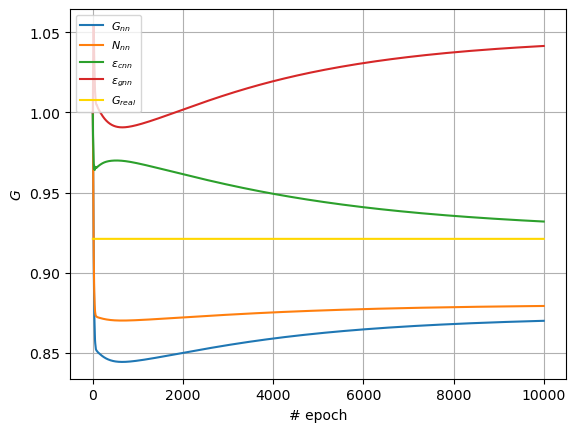

In [11]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')
print(G_real)
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")

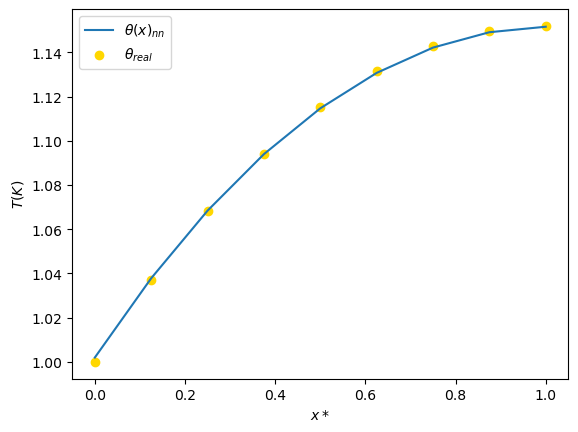

In [12]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='upper left', prop={'size': 10})

## Train with LBFGS

In [54]:
'Neural Network Summary'
pinn = PINN(layers)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'''Optimization'''

'Store losses and predicted G values'
# loss_theta = np.zeros((steps,))
# loss_f = np.zeros((steps,))
# loss_bc = np.zeros((steps,))
# loss_hist = [ ]
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))

'L-BFGS Optimizer'
optimizer = torch.optim.LBFGS(params, lr, 
                              max_iter = steps, 
                              max_eval = None, 
                              tolerance_grad = 1e-11, 
                              tolerance_change = 1e-11, 
                              line_search_fn = 'strong_wolfe',
                              history_size = 100)

optimizer.step(pinn.closure)


print(pinn.iter)

# 'Train the model'
# for epoch in range(steps):
    
#     if (epoch)%(steps // 100) == 0:
        
#         print(
#             'Epoch: %.0d, G =  %.2f, loss_bc = %.6f, loss_d = %.6f, loss_pde = %.6f' %
#             (
#             epoch,
#             G_hist[epoch],
#             loss_bc[epoch],
#             loss_theta[epoch],
#             loss_f[epoch]
#             )
#         )
        
    
# #     test_error, _ = pinn.test()
# print(pinn.iter)




588


# Losses vs num epochs 

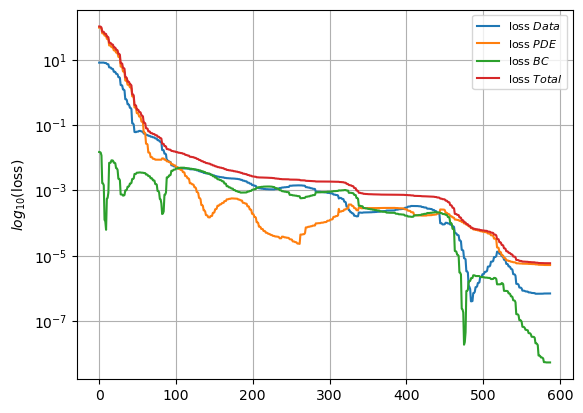

In [55]:
plt.cla()
# plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
# plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(pinn.loss_history["Data"] , label = r'loss $Data$')
plt.plot(pinn.loss_history["PDE"] , label = r'loss $PDE$')
plt.plot(pinn.loss_history["BC"] , label = r'loss $BC$')
plt.plot(pinn.loss_history["Total"] , label = r'loss $Total$')
# plt.plot(range(steps),loss_bc, label = r'loss $BC$')
# plt.plot(range(steps),loss_theta + loss_f)

plt.legend(loc='upper right', prop={'size': 8})
# plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

## PDE Parameters ($G$, $N$, $\epsilon_c$, $\epsilon_g$) value vs num epochs

[[0.92105906]]


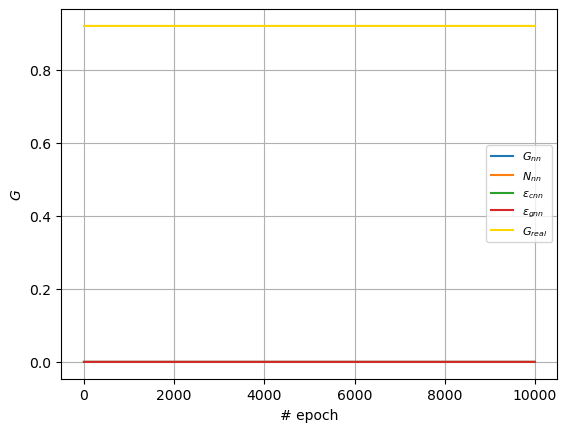

In [15]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')
print(G_real)
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")


##  Plot $\theta(x)$ solution

588

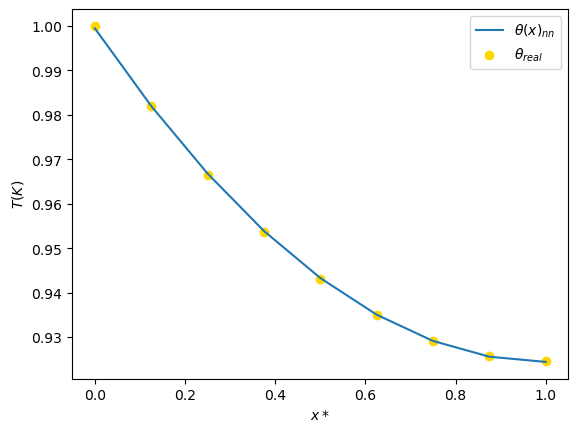

In [56]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')

plt.xlabel('$x*$')
plt.ylabel('$T(K)$')
plt.legend(loc='best', prop={'size': 10})
pinn.iter


In [57]:
print(pinn.G, pinn.ec, pinn.eg, pinn.N)

Parameter containing:
tensor([-0.4106], requires_grad=True) Parameter containing:
tensor([0.9917], requires_grad=True) Parameter containing:
tensor([0.5103], requires_grad=True) Parameter containing:
tensor([0.4360], requires_grad=True)


## Make some noise! 

In [17]:
deviation_T =  T_real.std()
alpha_dev = .01
noise_dev_std = deviation_T * alpha_dev 

T_real_noisy = torch.from_numpy(T_real) 
noise_T = torch.normal(0, noise_dev_std, T_real.shape)
T_real_noisy += noise_T
Theta_noisy = torch.multiply(torch.add(T_real_noisy, torch.tensor([-T_inf])), torch.tensor([1/(T_b - T_inf)]))
# Hardcode the dirichlet bc value 
Theta_noisy[0] = 1.0
Theta_noisy = Theta_noisy.type(torch.Tensor)
'Neural Network Summary'
pinn = PINN(layers)

'Neural Network Parameters'
params = list(pinn.dnn.parameters())

'L-BFGS Optimizer'
optimizer = torch.optim.Adam(params, lr, 
                             amsgrad = True)

'Store losses and predicted G values'
loss_theta = np.zeros((steps,))
loss_f = np.zeros((steps,))
loss_bc = np.zeros((steps,))
loss_hist = np.zeros((steps,))
G_hist = np.zeros((steps,))
N_hist = np.zeros((steps,))
ec_hist = np.zeros((steps,))
eg_hist = np.zeros((steps,))

'Train the model'
for epoch in range(steps):
    if epoch%20 == 0:
        print('Voy en la vuelta número {} y G = {}'.format(epoch-1,G_hist[epoch - 1]))
    # compute net U prediction
    theta_nn = pinn.dnn(X_real)
    # compute losses
    loss_theta[epoch] = pinn.loss_data(X_real, Theta_noisy).to('cpu').detach().numpy()
    loss_f[epoch]     = pinn.loss_PDE(X_train_f).to('cpu').detach().numpy()
    loss_bc[epoch]    = pinn.loss_BC(X_bc).to('cpu').detach().numpy()
    loss = pinn.loss(X_real, Theta_noisy, X_train_f,X_bc)
    loss_hist[epoch] = loss.to('cpu').detach().numpy()
    # store parameters 
    G_hist[epoch], N_hist[epoch], ec_hist[epoch], eg_hist[epoch]  = pinn.G, pinn.N, pinn.ec, pinn.eg
    
    # update parameters
    optimizer.zero_grad()       # Zero Out the gradient
    loss.backward()    
    optimizer.step()
    
    test_error, _ = pinn.test()


Voy en la vuelta número -1 y G = 0.0
Voy en la vuelta número 19 y G = 0.9075739979743958
Voy en la vuelta número 39 y G = 0.848609209060669
Voy en la vuelta número 59 y G = 0.833060622215271
Voy en la vuelta número 79 y G = 0.8278552889823914
Voy en la vuelta número 99 y G = 0.826654851436615
Voy en la vuelta número 119 y G = 0.8258431553840637
Voy en la vuelta número 139 y G = 0.8252646923065186
Voy en la vuelta número 159 y G = 0.8247162699699402
Voy en la vuelta número 179 y G = 0.8241930603981018
Voy en la vuelta número 199 y G = 0.8237108588218689
Voy en la vuelta número 219 y G = 0.8232583403587341
Voy en la vuelta número 239 y G = 0.8228352665901184
Voy en la vuelta número 259 y G = 0.8224402666091919
Voy en la vuelta número 279 y G = 0.8220727443695068
Voy en la vuelta número 299 y G = 0.8217322826385498
Voy en la vuelta número 319 y G = 0.8214184045791626
Voy en la vuelta número 339 y G = 0.8211305737495422
Voy en la vuelta número 359 y G = 0.8208677172660828
Voy en la vuelta 

Voy en la vuelta número 3079 y G = 0.8276119828224182
Voy en la vuelta número 3099 y G = 0.8277170062065125
Voy en la vuelta número 3119 y G = 0.8278219103813171
Voy en la vuelta número 3139 y G = 0.8279268145561218
Voy en la vuelta número 3159 y G = 0.8280317187309265
Voy en la vuelta número 3179 y G = 0.8281366229057312
Voy en la vuelta número 3199 y G = 0.8282415270805359
Voy en la vuelta número 3219 y G = 0.8283464312553406
Voy en la vuelta número 3239 y G = 0.8284513354301453
Voy en la vuelta número 3259 y G = 0.82855623960495
Voy en la vuelta número 3279 y G = 0.8286611437797546
Voy en la vuelta número 3299 y G = 0.8287660479545593
Voy en la vuelta número 3319 y G = 0.828870952129364
Voy en la vuelta número 3339 y G = 0.8289758563041687
Voy en la vuelta número 3359 y G = 0.8290807604789734
Voy en la vuelta número 3379 y G = 0.8291856646537781
Voy en la vuelta número 3399 y G = 0.829289972782135
Voy en la vuelta número 3419 y G = 0.8293936848640442
Voy en la vuelta número 3439 y G

Voy en la vuelta número 6119 y G = 0.8420321345329285
Voy en la vuelta número 6139 y G = 0.842113196849823
Voy en la vuelta número 6159 y G = 0.8421942591667175
Voy en la vuelta número 6179 y G = 0.8422742486000061
Voy en la vuelta número 6199 y G = 0.8423541188240051
Voy en la vuelta número 6219 y G = 0.8424339890480042
Voy en la vuelta número 6239 y G = 0.8425138592720032
Voy en la vuelta número 6259 y G = 0.8425937294960022
Voy en la vuelta número 6279 y G = 0.8426731824874878
Voy en la vuelta número 6299 y G = 0.8427518606185913
Voy en la vuelta número 6319 y G = 0.8428305387496948
Voy en la vuelta número 6339 y G = 0.8429092168807983
Voy en la vuelta número 6359 y G = 0.8429878950119019
Voy en la vuelta número 6379 y G = 0.8430665731430054
Voy en la vuelta número 6399 y G = 0.8431448936462402
Voy en la vuelta número 6419 y G = 0.8432223796844482
Voy en la vuelta número 6439 y G = 0.8432998657226562
Voy en la vuelta número 6459 y G = 0.8433773517608643
Voy en la vuelta número 6479 

KeyboardInterrupt: 

In [ ]:
plt.cla()
plt.plot(range(steps),loss_theta, label = r'loss $\theta_{nn} - \theta_{m}$')
plt.plot(range(steps),loss_f, label = r'loss $f_{PDE}$')
plt.plot(range(steps),loss_hist, label = r'loss $PINN$')
plt.plot(range(steps),loss_bc, label = r'loss $BC$')
# plt.plot(range(steps),loss_theta + loss_f)

plt.legend(loc='upper right', prop={'size': 8})
plt.xlabel('# epoch')
plt.yscale('log')
plt.ylabel(r'$log_{10}$(loss)')
plt.grid(True, which="both", ls="-")
# plt.savefig('part1_outputs/figures/loss_vs_nepoch_without_norm.png')
plt.show()

In [ ]:
plt.cla()
plt.plot(range(steps), G_hist, label = r'$G_{nn}$')
plt.plot(range(steps), N_hist, label = r'$N_{nn}$')
plt.plot(range(steps), ec_hist, label = r'$\epsilon_{cnn}$')
plt.plot(range(steps), eg_hist, label = r'$\epsilon_{gnn}$')
print(G_real)
plt.plot(range(steps), G_real*np.ones((steps,1)), label = r'$G_{real}$', color = 'gold')
plt.legend(loc='best', prop={'size': 8})
plt.xlabel('# epoch')
plt.ylabel(r'$G$')
plt.grid(True, which="both", ls="-")


In [ ]:
# compute theta values
x_u = X_real
theta_real = Theta_real.to('cpu').detach().numpy()
theta_noisy = Theta_noisy.to('cpu').detach().numpy()
x_f = X_train_f.to('cpu').detach().numpy()
theta_nn = pinn.forward(X_real).to('cpu').detach().numpy()

# plt.cla()
plt.plot(x_u, theta_nn, label = r'$\theta(x)_{nn}$')
plt.scatter(x_u, theta_real, label = r'$\theta_{real}$', color = 'gold')
plt.scatter(x_u, theta_noisy, label = r'$\theta_{noisy}$', color = 'red')

plt.xlabel('$x*$')
plt.ylabel(r'$\theta$')
plt.legend(loc='upper left', prop={'size': 10})

## Questions 
- Discutir resultados de la parte a) 
- Se le agrega ruido al $\theta_b$ ?